# 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
sys.path.append(os.pardir)
sys.path.append('/content/drive/My Drive/dacon')
my_path = '/content/drive/My Drive/dacon/'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from xgboost import XGBRegressor
import xgboost

# nltk packages

import nltk # 문장 토크나이저
nltk.download('all')
from nltk.corpus import names #corpus=말뭉치,이름 관련 부분 다루기 위한 객체
from nltk.corpus import stopwords # 영어 불용어 - 불용어 모아 놓은 리스트 다운로드해 제거
from nltk.tokenize import word_tokenize # 토큰화
from nltk.stem.porter import PorterStemmer # 어근 동일화 <-> 이거 말고도 "Lancaster Stemmer"
# 표제어 추출
from nltk.stem import WordNetLemmatizer
# 정규표현 처리
import re


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [4]:
train = pd.read_csv('/content/drive/MyDrive/dacon/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon/test.csv')
sample_submission = pd.read_csv("/content/drive/MyDrive/dacon/sample_submission.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [42]:
train1 = train.copy()

In [43]:
test1 = test.copy()

# Data Preprocessing

# facts에서 first_party -> p1, second_party -> p2로 이름 통일

In [44]:
train1['facts1'] = train1['facts']

In [45]:
train1['first_party1'] = train1['first_party'].str.strip()
train1['second_party1'] = train1['second_party'].str.strip()

In [46]:
train1['first_party1']

0                                  Phil A. St. Amant
1                                     Stephen Duncan
2                                  Billy Joe Magwood
3                                         Linkletter
4                                 William Earl Fikes
                            ...                     
2473    HollyFrontier Cheyenne Refining, LLC, et al.
2474             Grupo Mexicano de Desarrollo, S. A.
2475                                         Peguero
2476          Immigration and Naturalization Service
2477                                         Markman
Name: first_party1, Length: 2478, dtype: object

In [47]:
train1['first_party1'] = train1['first_party1'].str.replace(" ", "|")
train1['second_party1'] = train1['second_party1'].str.replace(" ", "|")

In [48]:
train1['first_party1']

0                                  Phil|A.|St.|Amant
1                                     Stephen|Duncan
2                                  Billy|Joe|Magwood
3                                         Linkletter
4                                 William|Earl|Fikes
                            ...                     
2473    HollyFrontier|Cheyenne|Refining,|LLC,|et|al.
2474             Grupo|Mexicano|de|Desarrollo,|S.|A.
2475                                         Peguero
2476          Immigration|and|Naturalization|Service
2477                                         Markman
Name: first_party1, Length: 2478, dtype: object

In [49]:
train1['second_party1']

0                        Herman|A.|Thompson
1                            Lawrence|Owens
2            Tony|Patterson,|Warden,|et|al.
3                                    Walker
4                                   Alabama
                       ...                 
2473    Renewable|Fuels|Association,|et|al.
2474               Alliance|Bond|Fund,|Inc.
2475                          United|States
2476                                St.|Cyr
2477             Westview|Instruments,|Inc.
Name: second_party1, Length: 2478, dtype: object

In [50]:
train1.head()

,ID,first_party,second_party,facts,first_party_winner,facts1,first_party1,second_party1
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"On June 27, 1962, Phil St. Amant, a candidate ...",Phil|A.|St.|Amant,Herman|A.|Thompson
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,Ramon Nelson was riding his bike when he suffe...,Stephen|Duncan,Lawrence|Owens
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,An Alabama state court convicted Billy Joe Mag...,Billy|Joe|Magwood,"Tony|Patterson,|Warden,|et|al."
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,Victor Linkletter was convicted in state court...,Linkletter,Walker
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"On April 24, 1953 in Selma, Alabama, an intrud...",William|Earl|Fikes,Alabama


In [51]:
test1['facts1'] = test1['facts']

In [52]:
test1['first_party1'] = test1['first_party'].str.strip()
test1['second_party1'] = test1['second_party'].str.strip()

In [53]:
test1['first_party1'] = test1['first_party1'].str.replace(" ", "|")
test1['second_party1'] = test1['second_party1'].str.replace(" ", "|")

In [54]:
test1['first_party1']

0                                                 Salerno
1                  Milberg|Weiss|Bershad|Hynes|and|Lerach
2       No.|07-582\t|Title:|\t|Federal|Communications|...
3                                          Harold|Kaufman
4                                                  Berger
                              ...                        
1235                Haitian|Centers|Council,|Inc.,|et|al.
1236                                              Whitman
1237                  Linda|A.|Matteo|and|John|J.|Madigan
1238        Washington|State|Apple|Advertising|Commission
1239                                     Theodore|Stovall
Name: first_party1, Length: 1240, dtype: object

In [55]:
test1['second_party1']

0                                           United|States
1                                           Lexecon,|Inc.
2                   Fox|Television|Stations,|Inc.,|et|al.
3                                           United|States
4                                                  Hanlon
                              ...                        
1235    Chris|Sale,|Acting|Commissioner,|Immigration|A...
1236                 American|Trucking|Associations,|Inc.
1237                                      William|G.|Barr
1238                                                 Hunt
1239                                Wilfred|Denno,|Warden
Name: second_party1, Length: 1240, dtype: object

In [56]:
def replace_name(name, text, replace_word):
    names = name.split('|')
    words = text.split()
    for word in words:
      for n in names:
        if n in word:
            text = text.replace(word, replace_word)

    return text

In [21]:
# 테스트
# print(replace_name(test1['first_party1'][3],test1['facts'][3],'first_party1'))

During his trial for armed robbery of a federally insured savings and loan association, first_party1 first_party1 admitted to the crime but unsuccessfully claimed insanity.  He was convicted and the U.S. Court of Appeals for the Eighth Circuit affirmed.  first_party1 then filed a post-conviction motion in district court challenging the evidence that proved his sanity.  He alleged that the evidence was unlawfully seized in violation of the Fourth Amendment.  The district court denied relief, holding that unlawful search and seizure was not an available attack in post-conviction proceedings.  The Eighth Circuit affirmed.



In [57]:
for i in range(2478):
  train1['facts1'][i] = replace_name(train1['first_party1'][i], train1['facts1'][i], 'p1')
  train1['facts1'][i] = replace_name(train1['second_party1'][i], train1['facts1'][i], 'p2')

<ipython-input-57-c688c6cba725>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['facts1'][i] = replace_name(train1['first_party1'][i], train1['facts1'][i], 'p1')
<ipython-input-57-c688c6cba725>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['facts1'][i] = replace_name(train1['second_party1'][i], train1['facts1'][i], 'p2')


In [58]:
print(train1['facts1'][0])

On June 27, 1962, p1 p1 p1 a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, p1 p1 accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, p1 p1 implicated p2 p2 an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and p1 p1’s political opponent. 
p2 successfully sued p1 p1 for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that p2 did not show p1 p1 acted with “malice.”  p2 then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, p1 p1 accused p2 of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens

In [59]:
for i in range(1240):
  test1['facts1'][i] = replace_name(test1['first_party1'][i], test1['facts1'][i], 'p1')
  test1['facts1'][i] = replace_name(test1['second_party1'][i], test1['facts1'][i], 'p2')

In [61]:
test1['facts1'][3]

'During his trial for armed robbery of a federally insured savings and loan association, p1 p1 admitted to the crime but unsuccessfully claimed insanity.  He was convicted and the U.S. Court of Appeals for the Eighth Circuit affirmed.  p1 then filed a post-conviction motion in district court challenging the evidence that proved his sanity.  He alleged that the evidence was unlawfully seized in violation of the Fourth Amendment.  The district court denied relief, holding that unlawful search and seizure was not an available attack in post-conviction proceedings.  The Eighth Circuit affirmed.\n'

## 정규표현식으로 first_party 여러번 중복 연달아 나오는 거 한 번만 나오게 바꾸기

In [62]:
import re

def remove_duplicates(text):
    modified_text1 = re.sub(r'(p1\s*)+', 'p1 ', text)
    modified_text2 = re.sub(r'(p2\s*)+', 'p2 ', modified_text1)

    return modified_text2

In [63]:
for i in range(2478):
  train1['facts1'][i] = remove_duplicates(train1['facts1'][i])

<ipython-input-63-d337d326c215>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['facts1'][i] = remove_duplicates(train1['facts1'][i])


In [64]:
train1['facts1'][0]

'On June 27, 1962, p1 a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, p1 accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, p1 implicated p2 an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and p1 ’s political opponent. \np2 successfully sued p1 for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that p2 did not show p1 acted with “malice.”  p2 then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, p1 accused p2 of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens to be a public servant.

In [65]:
for i in range(1240):
  test1['facts1'][i] = remove_duplicates(test1['facts1'][i])

In [66]:
test1['facts1'][3]

'During his trial for armed robbery of a federally insured savings and loan association, p1 admitted to the crime but unsuccessfully claimed insanity.  He was convicted and the U.S. Court of Appeals for the Eighth Circuit affirmed.  p1 then filed a post-conviction motion in district court challenging the evidence that proved his sanity.  He alleged that the evidence was unlawfully seized in violation of the Fourth Amendment.  The district court denied relief, holding that unlawful search and seizure was not an available attack in post-conviction proceedings.  The Eighth Circuit affirmed.\n'

In [67]:
train1.head()

,ID,first_party,second_party,facts,first_party_winner,facts1,first_party1,second_party1
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"On June 27, 1962, p1 a candidate for public of...",Phil|A.|St.|Amant,Herman|A.|Thompson
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,Ramon Nelson was riding his bike when he suffe...,Stephen|Duncan,Lawrence|Owens
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,An Alabama state court convicted p1 of murder ...,Billy|Joe|Magwood,"Tony|Patterson,|Warden,|et|al."
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,Victor p1 was convicted in state court on evid...,Linkletter,Walker
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"On April 24, 1953 in Selma, p2 an intruder bro...",William|Earl|Fikes,Alabama


In [68]:
test1.head()

,ID,first_party,second_party,facts,facts1,first_party1,second_party1
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...,The 1984 Bail Reform Act allowed the federal c...,Salerno,United|States
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...,Lexecon p2 was a defendant in a class action l...,Milberg|Weiss|Bershad|Hynes|and|Lerach,"Lexecon,|Inc."
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa...","In 2002 and 2003, p2 Stations broadcast the Bi...",No.|07-582\t|Title:|\t|Federal|Communications|...,"Fox|Television|Stations,|Inc.,|et|al."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...,During his trial for armed robbery of a federa...,Harold|Kaufman,United|States
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a...","In 1993, a magistrate judge issued a warrant a...",Berger,Hanlon


In [71]:
for i in train1.facts1:
  if 'p1 p1' in i:
    print('error')
  if 'p2 p2' in i:
    print('error')

In [72]:
for i in test1.facts1:
  if 'p1 p1' in i:
    print('error')
  if 'p2 p2' in i:
    print('error')

# 파생변수 생성
## 1. 문장, 단어 길이 컬럼

In [ ]:
train1['sen_len'] = 0 # 문장 토큰화
train1['word_len'] = 0 # 단어 토큰화

for i in range(len(train1)):
  train1.sen_len[i] = len(nltk.sent_tokenize(train1.facts[i]))
  train1.word_len[i] = len(word_tokenize(train1.facts[i]))

train2 = train1[['ID', 'first_party', 'second_party', 'facts1', 'sen_len', 'word_len', 'first_party_winner']]
train2 = train2.rename(columns={'facts1':'facts'})
train2.head(10)

<ipython-input-23-09fecb3f705d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1.sen_len[i] = len(nltk.sent_tokenize(train1.facts[i]))
<ipython-input-23-09fecb3f705d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1.word_len[i] = len(word_tokenize(train1.facts[i]))


KeyboardInterrupt: ignored

In [ ]:
test1['sen_len'] = 0 # 문장 토큰화
test1['word_len'] = 0 # 단어 토큰화

for i in range(len(test1)):
  test1.sen_len[i] = len(nltk.sent_tokenize(test1.facts[i]))
  test1.word_len[i] = len(word_tokenize(test1.facts[i]))

test2 = test1[['ID', 'first_party', 'second_party', 'facts1', 'sen_len', 'word_len']]
test2 = test2.rename(columns={'facts1':'facts'})
test2.head(10)

<ipython-input-31-6da581360e03>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1.sen_len[i] = len(nltk.sent_tokenize(test1.facts[i]))
<ipython-input-31-6da581360e03>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1.word_len[i] = len(word_tokenize(test1.facts[i]))


,ID,first_party,second_party,facts,sen_len,word_len
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...,2,55
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon second_party was a defendant in a clas...,7,209
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, second_party Stations broadc...",7,181
3,TEST_0003,Harold Kaufman,United States,first_pfirst_pfirst_party rtyrty first_pfirst_...,6,99
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a...",6,154
5,TEST_0005,Air Line Pilots Association,Miller,"The first_party (ALPA), a private-sector labor...",9,163
6,TEST_0006,Traffic Stream (BVI) Infrastructure Ltd.,JPMorgan Chase Bank,first_party is a corporation organized under t...,5,177
7,TEST_0007,NRG Power Marketing LLC et al.,Maine Public Utilities Commission et al.,The second_party along with the attorneys gene...,7,194
8,TEST_0008,United States,Deondery Chambers,second_party pled guilty to being a felon in p...,8,243
9,TEST_0009,United States Catholic Conference,"Abortion Rights Mobilization, Inc.",second_party and a collection of tax-paying an...,6,225


# KeyBert로 facts컬럼 summarize(문장으로)
## 1. default 옵션

In [ ]:
!pip install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.7 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23777 sha256=141ed787aa95790df0f15c1f7f6db260f03b7dd8471cf306ff5d664c0407ee22
  Stored in directory: /root/.cache/pip/wheels/66/8d/e6/b0e2f8d883b0fd51819226f67ad9843e04913ce4a97241ff4b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3

In [ ]:
from keybert import KeyBERT

In [ ]:
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(train1['facts'],keyphrase_ngram_range=(2,4),use_maxsum = True,top_n = 20)

In [ ]:
keywords

[[('amant accused political opponent', 0.5834),
  ('defamation louisiana circuit', 0.5861),
  ('amant accused thompson crime', 0.5875),
  ('amendment protection defamation', 0.5932),
  ('defamation louisiana', 0.5945),
  ('protection defamation st amant', 0.606),
  ('amant accused thompson', 0.6087),
  ('sued st amant defamation', 0.609),
  ('st amant accused', 0.6095),
  ('st amant accused political', 0.6107),
  ('defamation st amant', 0.6122),
  ('defamation louisiana circuit court', 0.6167),
  ('speech st amant accused', 0.6182),
  ('amendment protection defamation st', 0.6191),
  ('st amant defamation', 0.631),
  ('amant defamation louisiana circuit', 0.6401),
  ('defamation st amant accused', 0.6464),
  ('st amant accused thompson', 0.656),
  ('amant defamation louisiana', 0.6665),
  ('st amant defamation louisiana', 0.6967)],
 [('owens bench trial ruled', 0.5218),
  ('bench trial ruled owens', 0.5236),
  ('owens guilty degree murder', 0.5284),
  ('lineup tried convicted nelson', 

In [ ]:
keywords[0]

[('amant accused political opponent', 0.5834),
 ('defamation louisiana circuit', 0.5861),
 ('amant accused thompson crime', 0.5875),
 ('amendment protection defamation', 0.5932),
 ('defamation louisiana', 0.5945),
 ('protection defamation st amant', 0.606),
 ('amant accused thompson', 0.6087),
 ('sued st amant defamation', 0.609),
 ('st amant accused', 0.6095),
 ('st amant accused political', 0.6107),
 ('defamation st amant', 0.6122),
 ('defamation louisiana circuit court', 0.6167),
 ('speech st amant accused', 0.6182),
 ('amendment protection defamation st', 0.6191),
 ('st amant defamation', 0.631),
 ('amant defamation louisiana circuit', 0.6401),
 ('defamation st amant accused', 0.6464),
 ('st amant accused thompson', 0.656),
 ('amant defamation louisiana', 0.6665),
 ('st amant defamation louisiana', 0.6967)]

list to csv

In [ ]:
import csv

# field names
fields = ['keywords of facts']

# data rows of csv file
rows = keywords

with open('keywords_of_facts.csv', 'w',newline='') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)

    write.writerow(fields)
    write.writerows(rows)

##옵션 mmr

In [ ]:
kw_model = KeyBERT()
keywords_mmr = kw_model.extract_keywords(train1['facts'],keyphrase_ngram_range=(2,4),use_mmr = True,top_n = 20,diversity = 0.3)
keywords_mmr

[[('st amant defamation louisiana', 0.6967),
  ('amant defamation louisiana', 0.6665),
  ('st amant accused thompson', 0.656),
  ('defamation st amant accused', 0.6464),
  ('amant defamation louisiana circuit', 0.6401),
  ('st amant defamation', 0.631),
  ('amendment protection defamation st', 0.6191),
  ('speech st amant accused', 0.6182),
  ('defamation louisiana circuit court', 0.6167),
  ('st amant accused political', 0.6107),
  ('st amant accused', 0.6095),
  ('amant accused thompson', 0.6087),
  ('amendment protection defamation', 0.5932),
  ('amant accused political opponent', 0.5834),
  ('malice thompson appealed supreme', 0.5589),
  ('successfully sued st amant', 0.5566),
  ('thompson successfully sued st', 0.5403),
  ('louisiana speech st amant', 0.5173),
  ('louisiana court held public', 0.4756),
  ('phil st amant candidate', 0.4302)],
 [('habeas corpus owens appealed', 0.6327),
  ('nelson owens guilty', 0.6119),
  ('knock nelson owens guilty', 0.5971),
  ('owens motive viol

요약문 결과 list를 csv로 저장

In [ ]:
import csv

# field names
fields = ['keywords of facts']

# data rows of csv file
rows = keywords_mmr

with open('keywords_of_facts_mmr.csv', 'w',newline='') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)

    write.writerow(fields)
    write.writerows(rows)

In [ ]:
# 벡터화 함수 적용
X = get_vector(vectorizer, train2, True)
Y = train["first_party_winner"]
X_train = np.asarray(X) # np.array 활용 및 적용
Y_train = np.asarray(Y)

X_test = get_vector(vectorizer, test2, False)

# KeyBert로 키워드(단어) 추출

In [ ]:
array_text = train1['facts'].to_numpy()

bow = []

kw_extractor = KeyBERT('distilbert-base-nli-mean-tokens')
for j in range(len(array_text)):
    keywords = kw_extractor.extract_keywords(array_text[j])
    bow.append(keywords)

In [ ]:
bow

[[('sheriff', 0.2292),
  ('criminal', 0.1451),
  ('june', 0.1434),
  ('louisiana', 0.117),
  ('political', 0.1001)],
 [('murder', 0.283),
  ('cocaine', 0.2663),
  ('convicted', 0.1309),
  ('baseball', 0.0611),
  ('eyewitness', 0.0556)],
 [('murder', 0.3835),
  ('convicted', 0.3233),
  ('death', 0.253),
  ('sentenced', 0.2374),
  ('sentencing', 0.236)],
 [('retrial', 0.3732),
  ('criminal', 0.3276),
  ('convicted', 0.3018),
  ('police', 0.2837),
  ('illegally', 0.2071)],
 [('intruder', 0.0625),
  ('police', 0.0367),
  ('death', 0.0283),
  ('daughter', -0.004),
  ('interrogation', -0.0042)],
 [('landfill', 0.1226),
  ('clarkstown', 0.0546),
  ('contractor', 0.012),
  ('police', 0.0046),
  ('indiana', -0.0062)],
 [('detainee', 0.3377),
  ('detainees', 0.3077),
  ('detention', 0.2827),
  ('detentions', 0.2776),
  ('detained', 0.2432)],
 [('injured', 0.2147),
  ('mailroom', 0.2124),
  ('employer', 0.169),
  ('employees', 0.1335),
  ('1990', 0.129)],
 [('murder', 0.3329),
  ('robbery', 0.280

In [ ]:
keywords_list = [[item[0] for item in sublist] for sublist in bow]
keywords_list

[['sheriff', 'criminal', 'june', 'louisiana', 'political'],
 ['murder', 'cocaine', 'convicted', 'baseball', 'eyewitness'],
 ['murder', 'convicted', 'death', 'sentenced', 'sentencing'],
 ['retrial', 'criminal', 'convicted', 'police', 'illegally'],
 ['intruder', 'police', 'death', 'daughter', 'interrogation'],
 ['landfill', 'clarkstown', 'contractor', 'police', 'indiana'],
 ['detainee', 'detainees', 'detention', 'detentions', 'detained'],
 ['injured', 'mailroom', 'employer', 'employees', '1990'],
 ['murder', 'robbery', 'antiterrorism', 'hispanic', 'prosecution'],
 ['baptist', 'tennessee', 'disqualified', 'unconstitutional', '1796'],
 ['brewers', 'beer', 'kentucky', 'wholesalers', 'indiana'],
 ['mississippi', 'election', 'voting', 'virginia', 'voters'],
 ['taxes', 'protest', 'tax', 'california', 'sued'],
 ['marriages', 'sued', 'kentucky', 'marriage', 'tennessee'],
 ['mismanagement', 'lawsuit', '2007', '2008', '2010'],
 ['accidents', 'accident', 'traffic', 'wife', 'died'],
 ['alien', 'alie

## 불필요한 단어 중복돼서 data cleaning 한 후 다시 키워드 추출해보자
### 클렌징 코드

In [ ]:
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
ps = nltk.stem.porter.PorterStemmer()
all_names=set(names.words())
lem = nltk.stem.wordnet.WordNetLemmatizer()

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 이름, 불용어(분석에 필요없는 토큰) 제거
    all_names=set(names.words())
    no_stops = [word for word in no_capitals if not word in all_names|stops]

    # 어근 추츨을 통한 텍스트 정규화 작업
    stemmer_words = [ps.stem(word) for word in no_stops]

    # 표제어 추출 Lemmatisation (convert the word into root word)
    lem_text = [lem.lemmatize(word) for word in stemmer_words]

    # back to string from list
    text = " ".join(lem_text)

    return text

In [ ]:
train1["fact_processing"] = train1["facts"].apply(cleaning)

train1["fact_processing"]

0       june phil st amant candid public offic made te...
1       ramon nelson ride bike suffer lethal blow back...
2       alabama state court convict billi joe magwood ...
3       victor linklett convict state court evid illeg...
4       april selma alabama intrud broke apart daughte...
                              ...                        
2473    congress amend clean air act energi polici act...
2474    allianc bond fund inc invest fund purchas appr...
2475    district court sentenc manuel peguero month im...
2476    march enrico st cyr law perman resid pled guil...
2477    herbert markman own patent system track cloth ...
Name: fact_processing, Length: 2478, dtype: object

In [ ]:
train1["fact_processing"][4]

'april selma alabama intrud broke apart daughter citi mayor daughter intrud struggl sever room abl seiz knife fled assail towel head victim could identifi defend trial polic apprehend william earl fike basi call privat citizen held open charg investig polic question fike hour place jail limit access anyon familiar nearli week treatment fike confess form answer interrog lead question five day later fike confess question second time confess admit trial evid fike testifi regard event surround interrog judg rule would subject unlimit cross examin juri convict fike sentenc death suprem court alabama affirm'

In [ ]:
array_text = train1['fact_processing'].to_numpy()

bow_cleaned = []

kw_extractor = KeyBERT('distilbert-base-nli-mean-tokens')
for j in range(len(array_text)):
    keywords1 = kw_extractor.extract_keywords(array_text[j])
    bow_cleaned.append(keywords1)

In [ ]:
keywords_cleaned = [[item[0] for item in sublist] for sublist in bow_cleaned]
keywords_cleaned

[['sheriff', 'louisiana', 'june', 'communist', 'baton'],
 ['murder', 'death', 'convict', 'prison', 'drug'],
 ['murder', 'prison', 'convict', 'death', 'alabama'],
 ['retrial', 'convict', 'trial', 'suprem', 'fourth'],
 ['april', 'daughter', 'selma', 'death', 'alabama'],
 ['clarkstown', 'indiana', 'contractor', 'landfil', 'suprem'],
 ['detain', 'detaine', 'demonstr', 'provid', 'statutori'],
 ['demonstr', 'mailroom', 'discrimin', 'lost', 'prohibit'],
 ['murder', 'robberi', 'convict', 'antiterror', 'death'],
 ['baptist', 'tennesse', 'declaratori', 'suprem', 'church'],
 ['beer', 'brewer', 'distributor', 'provid', 'indiana'],
 ['voter', 'mississippi', 'vote', 'virginia', 'elect'],
 ['california', 'tax', 'organ', 'refund', 'church'],
 ['michigan', 'ohio', 'provid', 'kentucki', 'tennesse'],
 ['lawsuit', 'financi', 'plaintiff', 'fiduciari', 'monetari'],
 ['automobil', 'traffic', 'provid', 'liabil', 'evalu'],
 ['alien', 'texa', 'unnam', 'school', 'law'],
 ['retrial', 'convict', 'conspiraci', 'cer

In [ ]:
train1['facts_keywords'] = keywords_cleaned

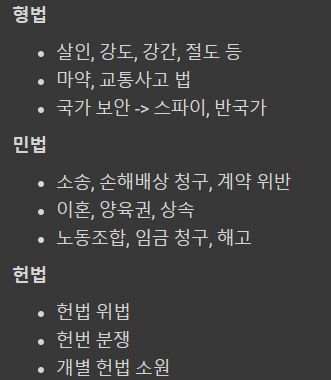

# 범죄 종류 분류 기준

In [ ]:
criminal = ['murder', 'robbery', 'rape', 'theft',
'drug', 'traffic', 'spy', 'espionage', 'anti-state']

civil = ['lawsuits', 'contract violations',
'divorce', 'child custody', 'inheritance',
'labor unions' , 'wage claims', 'terminations',
'Constitutional Law'
]

constitutional = ['Constitutional Petitions',
'constitutional disputes',
'individual constitutional rights']

df_crime_category = pd.DataFrame({
    'main_words':criminal + civil + constitutional,
    'category' : len(criminal)*["criminal"]+len(civil)*["civil"]+len(constitutional)*["constitutional"]
})

df_crime_category

# cleaning

In [ ]:
# len 변수들 안 합친 버전 df
train2 = train1[['ID', 'first_party', 'second_party', 'facts1', 'first_party_winner']]
train2 = train2.rename(columns={'facts1':'facts'})
test2 = test1[['ID', 'first_party', 'second_party', 'facts1']]
test2 = test2.rename(columns={'facts1':'facts'})

In [ ]:
# lst_stopwords = nltk.corpus.stopwords.words("english")
# ps = nltk.stem.porter.PorterStemmer()
# lem = nltk.stem.wordnet.WordNetLemmatizer()

# def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
#     ## clean (convert to lowercase and remove punctuations and characters and then strip)
#     text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

#     ## Tokenize (convert from string to list)
#     lst_text = text.split()    ## remove Stopwords
#     if lst_stopwords is not None:
#         lst_text = [word for word in lst_text if word not in
#                     lst_stopwords]

#     ## 어간추출 Stemming (remove -ing, -ly, ...)
#     if flg_stemm == True:
#         ps = nltk.stem.porter.PorterStemmer()
#         lst_text = [ps.stem(word) for word in lst_text]

#     ## 표제어 추출 Lemmatisation (convert the word into root word)
#     if flg_lemm == True:
#         lem = nltk.stem.wordnet.WordNetLemmatizer()
#         lst_text = [lem.lemmatize(word) for word in lst_text]

#     ## back to string from list
#     text = " ".join(lst_text)
#     return text

In [ ]:
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
ps = nltk.stem.porter.PorterStemmer()
all_names=set(names.words())
lem = nltk.stem.wordnet.WordNetLemmatizer()

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 이름, 불용어(분석에 필요없는 토큰) 제거
    all_names=set(names.words())
    no_stops = [word for word in no_capitals if not word in all_names|stops]

    # 어근 추츨을 통한 텍스트 정규화 작업
    stemmer_words = [ps.stem(word) for word in no_stops]

    # 표제어 추출 Lemmatisation (convert the word into root word)
    lem_text = [lem.lemmatize(word) for word in stemmer_words]

    # back to string from list
    text = " ".join(lem_text)

    return text

In [ ]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    # 데이터 클리닝
    df["fact_processing"] = df["facts"].apply(cleaning)

    # TF-IDF -- 파라미터 조정 필요?
    if train_mode:
        X_facts = vectorizer.fit_transform(df['fact_processing'])
    else:
        X_facts = vectorizer.transform(df['fact_processing'])

    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])

    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [ ]:
# 벡터화 함수 적용
X = get_vector(vectorizer, train2, True)
Y = train["first_party_winner"]
X_train = np.asarray(X) # np.array 활용 및 적용
Y_train = np.asarray(Y)

X_test = get_vector(vectorizer, test2, False)

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Cross Validation 이용해서 Train dataset을 Train / Validation dataset으로 분리

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size=0.2, stratify=Y_train,
                                                  random_state=1234)

ValueError: ignored

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((1982, 35379), (496, 35379), (1240, 35379))

In [ ]:
X_train.shape[0]

1982

In [ ]:
Y_val

1408    0
957     0
1397    1
2339    0
1881    1
       ..
1086    0
2253    0
2103    1
1586    1
1297    1
Name: first_party_winner, Length: 496, dtype: int64

# pycaret

In [ ]:
!pip install pycaret

In [ ]:
s# colab 환경 enable
from pycaret.utils import enable_colab

enable_colab()

ImportError: ignored

In [ ]:
# import
from pycaret.classification import *

In [ ]:
exp=setup(data=train2, target='first_party_winner')

,Description,Value
0,Session id,3005
1,Target,first_party_winner
2,Target type,Binary
3,Original data shape,"(2478, 6)"
4,Transformed data shape,"(2478, 6)"
5,Transformed train set shape,"(1734, 6)"
6,Transformed test set shape,"(744, 6)"
7,Categorical features,5
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_5 = compare_models(sort='Accuracy', n_select=5)

RuntimeError: ignored

In [ ]:
blended_l = blend_models(estimator_list = best_5, fold = 5, optimize = 'Accuracy')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)

# Define Model & Train
## lstm

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding,SimpleRNN,Dense
from keras.layers import Bidirectional,Dropout,GRU

In [ ]:
model3=Sequential()
model3.add(Embedding(X_train.shape[0]+1,500,input_length=35379))
model3.add(LSTM(128))
model3.add(Dropout(0.3))
model3.add(Dense(128,activation='relu'))
model3.add(Dense(64,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))
model3.summary()

In [ ]:
X_train = X_train[:, :, None] # 3차원으로 변환"

In [ ]:
X_train = X_train.reshape(1,X_train.shape[0],X_train.shape[1])

In [ ]:
X_train = X_train[:, :, None] # 3차원으로 변환?
# Y_train = Y_train[:, :, None]

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 1234)

from keras import Sequential
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(units=35379, input_shape = X_train.shape[1:], return_sequences = True))
model.add(LSTM(units=35379, return_sequences=True))
model.add(LSTM(units=35379, return_sequences=True))
model.add(LSTM(units=1, return_sequences=True, name='output'))
model.compile(loss='cosine_proximity', optimizer='sgd', metrics = ['accuracy'])

print(model.summary())

model.fit(X_train, Y_train, epochs=10, verbose=1)

ValueError: ignored

In [ ]:
model3.compile(loss='binary_crossentropy',metrics='acc',optimizer='adam')

In [ ]:
lstm = model3.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=10, steps_per_epoch=100, validation_steps=10, batch_size=32)

Epoch 1/10


InternalError: ignored

## Inference & Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
pred = model.predict(X_test)

In [ ]:
submit['first_party_winner'] = pred
submit.to_csv('./xgboost_grid_0622.csv', index=False)
print('Done')

Done
